In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import fastf1
from fastf1 import plotting
from scipy.interpolate import interp1d

In [2]:
fastf1.Cache.enable_cache('./f1_cache')
fastf1.Cache.get_cache_info()

('./f1_cache', 2728507204)

In [3]:
session = fastf1.get_session(2025, 13, 'Qualifying')
session.load()

core           INFO 	Loading data for Belgian Grand Prix - Qualifying [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '16', '1', '23', '63', '22', '6', '30', '5', '31', '87', '10', '27', '55', '44', '43', '12', '14', '18']


In [4]:
pia_color = plotting.get_driver_color(session=session,identifier='PIA')
nor_color = 'yellow'

req            INFO 	Using cached data for driver_info


In [16]:
nor_df = session.laps.pick_drivers('NOR').pick_fastest().telemetry[['Time','Distance','X','Y','Speed']].copy()
pia_df = session.laps.pick_drivers('PIA').pick_fastest().telemetry[['Time','Distance','X','Y','Speed']].copy()

In [17]:
nor_df['Seconds'] = nor_df['Time'].dt.total_seconds()
pia_df['Seconds'] = pia_df['Time'].dt.total_seconds()

In [18]:
# Norris
nor_time_interp = interp1d(nor_df['Distance'], nor_df['Seconds'], kind='linear', bounds_error=False, fill_value="extrapolate")
nor_x_interp    = interp1d(nor_df['Distance'], nor_df['X'], kind='linear', bounds_error=False, fill_value="extrapolate")
nor_y_interp    = interp1d(nor_df['Distance'], nor_df['Y'], kind='linear', bounds_error=False, fill_value="extrapolate")

# Piastri
pia_time_interp = interp1d(pia_df['Distance'], pia_df['Seconds'], kind='linear', bounds_error=False, fill_value="extrapolate")
pia_x_interp    = interp1d(pia_df['Distance'], pia_df['X'], kind='linear', bounds_error=False, fill_value="extrapolate")
pia_y_interp    = interp1d(pia_df['Distance'], pia_df['Y'], kind='linear', bounds_error=False, fill_value="extrapolate")

In [19]:
min_dist = max(pia_df['Distance'].min(), nor_df['Distance'].min())
max_dist = min(pia_df['Distance'].max(), nor_df['Distance'].max())

distance_grid = np.linspace(min_dist, max_dist, num=1000)

In [20]:
# Interpolated cumulative time
nor_time = pd.Series(nor_time_interp(distance_grid)).diff().dropna()
pia_time = pd.Series(pia_time_interp(distance_grid)).diff().dropna()

# Interpolated positions
y = (nor_x_interp(distance_grid) + pia_x_interp(distance_grid)) / 2
x = -(nor_y_interp(distance_grid) + pia_y_interp(distance_grid)) / 2

In [21]:
delta = pia_time - nor_time

# Assign colors
colors = np.where(delta < 0, pia_color, nor_color)

In [22]:
# Create line segments
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

In [23]:
import matplotlib.patches as mpatches

# Create legend handles manually
pia_patch = mpatches.Patch(color=pia_color, label='Piastri faster')
nor_patch = mpatches.Patch(color=nor_color, label='Norris faster')

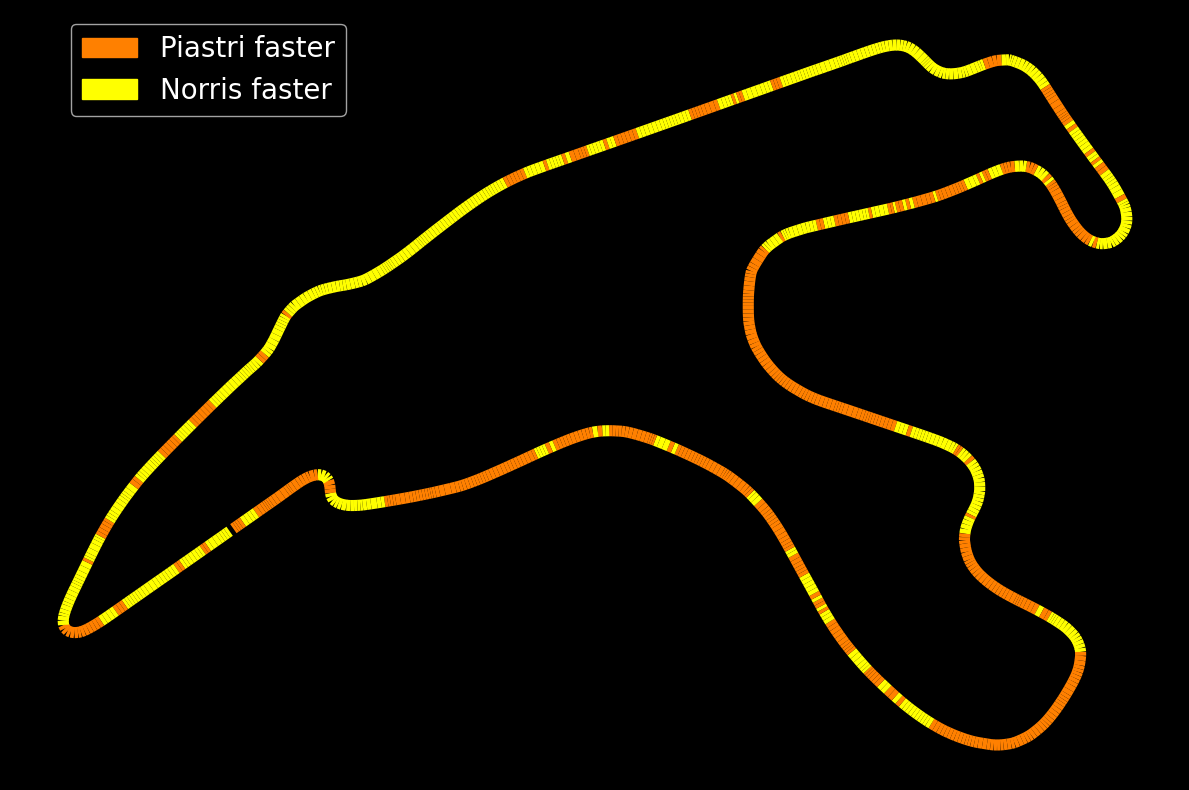

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor('#000000')
ax.axis('off')

# Color per segment (drop last color to match segments length)
lc = LineCollection(segments, colors=colors, linewidth=8)

ax.add_collection(lc)
ax.autoscale()

# Add legend to your axes
ax.legend(handles=[pia_patch, nor_patch],
          loc='upper left',  # or any location you prefer
          bbox_to_anchor=(0.04,1),
          frameon=True,
          facecolor='k',
          fontsize=20,
          labelcolor='white')

plt.tight_layout()
plt.show()